# Common Task 1 : Electron-Photon classification

## Import requisite libraries

### In addition to the standard libraries, we will be using functions defined in the [utils.py](./utils.py) file and arguments present in the [configs.py](./configs.py) file to complete the task.
### (Note: Arguments from [configs.py](./configs.py) are called in the [utils.py](./utils.py) file so we need not import them again in the notebook)

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from livelossplot import PlotLossesKeras
from utils import *


## Dataset creation

### First we extract the input features('X') and labels('y') from the .hdf5 files and concatenate them into different numpy arrays given by 'features' and 'labels' respectively.

In [2]:
electron_features, electron_labels = get_features_and_labels(file_dir = electron_dir)
photon_features, photon_labels = get_features_and_labels(file_dir = photon_dir)
features = np.concatenate((electron_features,photon_features), axis = 0)
labels = np.concatenate((electron_labels,photon_labels), axis = 0)

### We then shuffle the features and labels in the same order and split them into training, validation and test sets (following a 95-2.5-2.5 split). We set a 'random_state' in each of the following steps in order to ensure that the same split is obtained every time the code is run.

In [3]:
features, labels = shuffle(features, labels, random_state=42)

In [4]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    features,
    labels,
    test_size = 0.05,
    random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(473100, 32, 32, 2)
(473100,)
(12450, 32, 32, 2)
(12450,)
(12450, 32, 32, 2)
(12450,)


### A quick EDA of the labels reveals a reasonably balanced training dataset.

In [5]:
labels = {'0':0, '1':0}
for y in y_train:
    labels[str(int(y))]+=1
print(labels['0'])
print(labels['1'])

236591
236509


## Tensorflow model creation, training and evaluation

### We create a tensorflow model using the Sequential API and add the required layers to it. We obtain the model in the notebook using the 'get_tflow_model' function present in [utils.py](./utils.py). We have used [dropout](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) layers to prevent overfitting.

In [6]:
model = get_tflow_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        304       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          9

### We then compile the model using the ['binary_crossentropy'](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss function and the 'adam' optimizer. We use the ['AUC'](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC) metric to evaluate the model on the validation set at the end of every epoch.
### With the help of the [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback, we save the model weights for the epoch with the best validation AUC score. By making use of the [LearningRateScheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback, we reduce the learning rate by a factor of 0.1 for every epoch after the first 10 epochs as [learning rate decay](https://openreview.net/pdf?id=r1eOnh4YPB#:~:text=Learning%20rate%20decay%20(lrDecay)%20is,help%20both%20optimization%20and%20generalization.) imporves both optimization and generalization.

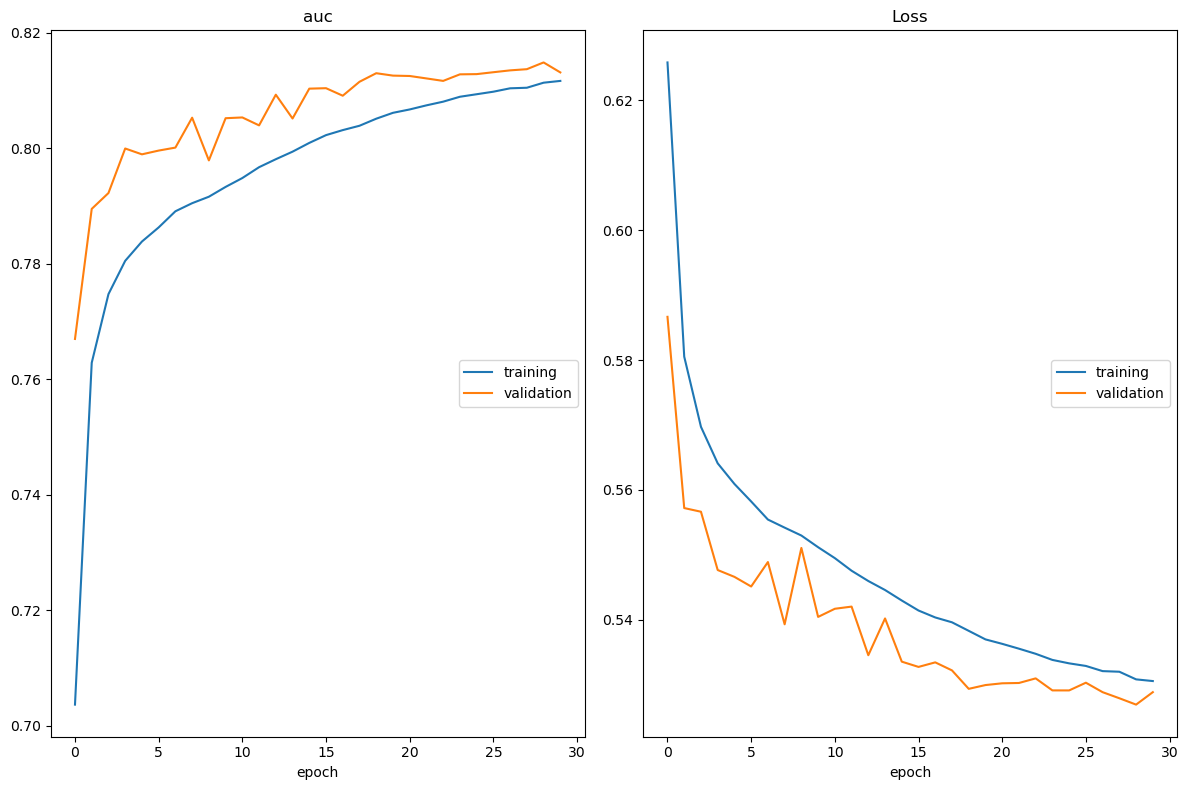

auc
	training         	 (min:    0.704, max:    0.812, cur:    0.812)
	validation       	 (min:    0.767, max:    0.815, cur:    0.813)
Loss
	training         	 (min:    0.531, max:    0.626, cur:    0.531)
	validation       	 (min:    0.527, max:    0.587, cur:    0.529)

Epoch 30: val_auc did not improve from 0.81488
7393/7393 [==============================] - 67s 9ms/step - loss: 0.5306 - auc: 0.8117 - val_loss: 0.5289 - val_auc: 0.8132 - lr: 1.3534e-04


In [7]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.AUC()]
)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    weights_path,
    monitor='val_auc',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)
model.fit(
    X_train, 
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_val, y_val),
    callbacks=[PlotLossesKeras(), lr_callback, ckpt],
    verbose=1,
    shuffle=True
)


### After training the model for 30 epochs, we load the model weights with the best validation AUC score and evaluate the model on the test set. The AUC score of 0.81 on the test set is above the required criteria of 0.80 in the task description, without overfitting as evident from the training and validation AUC scores and the learning curves. The model is thus able to generalize well to the test set even with a small number of parameters (30,465).

195/195 [==============================] - 6s 4ms/step


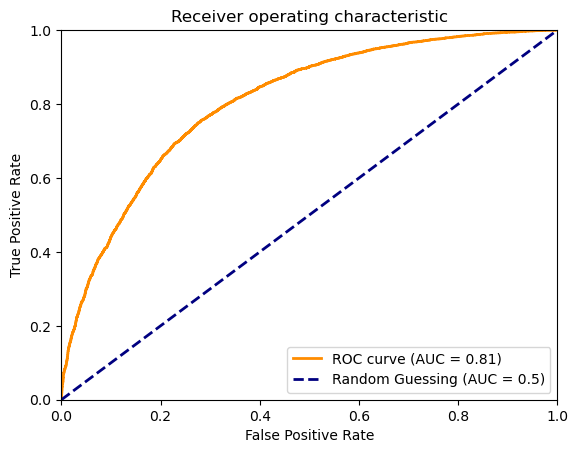

In [7]:
model.load_weights('./weights_tf/best_weights')
preds=model.predict(X_test, batch_size = 64, verbose = 1)
plot_ROC_AUC(y_test, preds)

## PyTorch subsection

### We first need to create the PyTorch dataloader objects for the training, validation and test sets. We use the [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) class to create the torch tensor datasets from numpy arrays and the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class to create the dataloaders.

In [6]:
train_loader = get_torch_data_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
val_loader = get_torch_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
#test_loader = get_torch_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)

### We create a checkpointing, logging and learning rate monitoring callback and use them to train our model

In [7]:
ckpt_callback = ModelCheckpoint(
    dirpath=weights_path_torch,
    filename='best_weights',
    save_top_k=1,
    verbose=True,
    monitor='val_auc',
    mode='max',
    save_weights_only=True
)
lr_callback = LearningRateMonitor(logging_interval='epoch')
logger = CSVLogger(save_dir=logs_path_torch, name='lightning_logs')
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=epochs,
    callbacks=[ckpt_callback, lr_callback],
    enable_progress_bar=True,
    logger=logger
)
lightning_module = ParticleClassifierLightning()
trainer.fit(lightning_module, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\abhim\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory C:\Users\abhim\ml4sci-tests\common-task-1\weights_torch exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | model | ParticleClassifier | 30.5 K
1 | loss  | BCELoss            | 0     
---------------------------------------------
30.5 K    Trainable params
0         Non-trainable params
30.5 K    Total params
0.122     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\abhim\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\abhim\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 7393: 'val_auc' reached 0.74854 (best 0.74854), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 14786: 'val_auc' reached 0.76497 (best 0.76497), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 22179: 'val_auc' reached 0.77404 (best 0.77404), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 29572: 'val_auc' reached 0.79132 (best 0.79132), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 36965: 'val_auc' reached 0.79332 (best 0.79332), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 44358: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 51751: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 59144: 'val_auc' reached 0.79848 (best 0.79848), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 66537: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 9.0484e-04.


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 73930: 'val_auc' reached 0.79935 (best 0.79935), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 8.1873e-04.


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 81323: 'val_auc' reached 0.80010 (best 0.80010), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 7.4082e-04.


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 88716: 'val_auc' reached 0.80108 (best 0.80108), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 6.7032e-04.


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 96109: 'val_auc' reached 0.80374 (best 0.80374), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 6.0653e-04.


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 103502: 'val_auc' reached 0.80437 (best 0.80437), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 5.4881e-04.


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 110895: 'val_auc' reached 0.80642 (best 0.80642), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 4.9659e-04.


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 118288: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 4.4933e-04.


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 125681: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 4.0657e-04.


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 133074: 'val_auc' reached 0.80824 (best 0.80824), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 3.6788e-04.


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 140467: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 3.3287e-04.


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 147860: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 3.0119e-04.


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 155253: 'val_auc' reached 0.80850 (best 0.80850), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 2.7253e-04.


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 162646: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 2.4660e-04.


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 170039: 'val_auc' reached 0.80975 (best 0.80975), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 2.2313e-04.


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 177432: 'val_auc' reached 0.81014 (best 0.81014), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 2.0190e-04.


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 184825: 'val_auc' reached 0.81019 (best 0.81019), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.8268e-04.


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 192218: 'val_auc' reached 0.81112 (best 0.81112), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.6530e-04.


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 199611: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 1.4957e-04.


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 207004: 'val_auc' was not in top 1


Adjusting learning rate of group 0 to 1.3534e-04.


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 214397: 'val_auc' reached 0.81119 (best 0.81119), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\common-task-1\\weights_torch\\best_weights-v2.ckpt' as top 1


Adjusting learning rate of group 0 to 1.2246e-04.


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 221790: 'val_auc' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


### We plot the learning curves

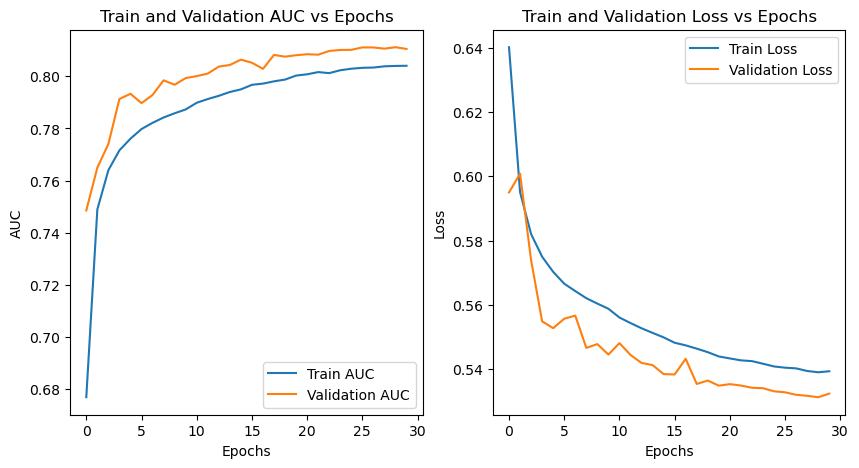

In [2]:
file_path = logs_path_torch +'/lightning_logs/version_0/metrics.csv'
plot_learning_curves(file_path)

### We then load the model with the best validation AUC score and evaluate it on the test set. The AUC score of 0.8024 is above the required criteria of 0.80 without overfitting as evident from the training and validation AUC scores and the learning curves. The model is thus able to generalize well to the test set even with a small number of parameters (30.5K).

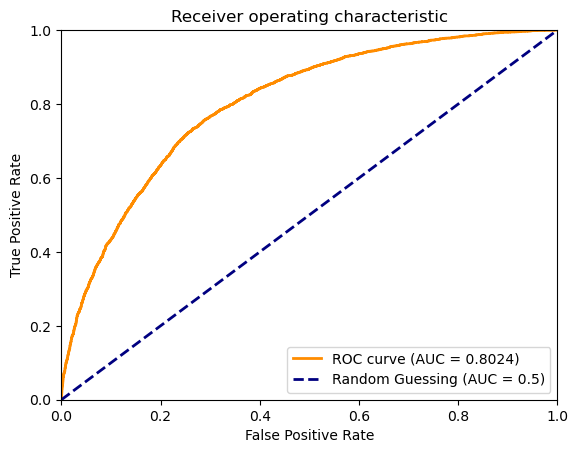

In [6]:
best_model = ParticleClassifierLightning.load_from_checkpoint(
    checkpoint_path = weights_path_torch+'/best_weights-v2.ckpt'
)
best_model.eval()
predicitions = best_model(torch.from_numpy(X_test).permute(0,3,1,2)) 
predicitions = predicitions.detach().numpy()
plot_ROC_AUC(y_test, predicitions)